In [5]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from utide import solve

# latitude of tide gauge (needed for tidal analysis)
lat = 56.550

### Data Source

* Raw, hourly sea level data for Nain (Station #1430) downloaded from [DFO](https://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/inventory-inventaire/sd-ds-eng.asp?no=1430&user=isdm-gdsi&region=ATL). This dataset goes from 1963-2021.

In [6]:
# read data into `pandas.DataFrame`
df = pd.read_csv(
    'DFO1430_full.csv',                         # Data downloaded from DFO 1430
    header=7,                                   # Seven line header
    parse_dates=[['Obs_date', 'Obs_time']],     # Identify date & time columns
)

# convert columns with date/time information to datetime object
df["time"] = pd.to_datetime(df["Obs_date_Obs_time"])

# remove the columns with date/time information
df = df.drop(["Obs_date_Obs_time"], axis=1)

# use the datetime object as index
df = df.set_index("time")
df

,SLEV(metres)
time,
1963-10-17 05:00:00,0.53
1963-10-17 06:00:00,0.65
1963-10-17 07:00:00,0.97
1963-10-17 08:00:00,1.38
1963-10-17 09:00:00,1.87
...,...
2021-12-31 00:00:00,0.99
2021-12-31 01:00:00,0.71
2021-12-31 02:00:00,0.59


In [7]:
# create a new index from the date range specified
# use hourly frequency to match the hourly gage data

index = pd.date_range('1963-10-17 ', '2021-12-31', freq='H')

# reassign new index to df
df=df.reindex(index=index)

# display the first 10 rows of the df
df.head(10)

,SLEV(metres)
1963-10-17 00:00:00,NaN
1963-10-17 01:00:00,NaN
1963-10-17 02:00:00,NaN
1963-10-17 03:00:00,NaN
1963-10-17 04:00:00,NaN
1963-10-17 05:00:00,0.53
1963-10-17 06:00:00,0.65
1963-10-17 07:00:00,0.97
1963-10-17 08:00:00,1.38
1963-10-17 09:00:00,1.87


### Figure: Raw Time Series

[Text(0.5, 1.0, 'Raw Hourly Sea Level Record for Nain (Source: DFO)'),
 Text(0, 0.5, 'Sea Level [m]')]

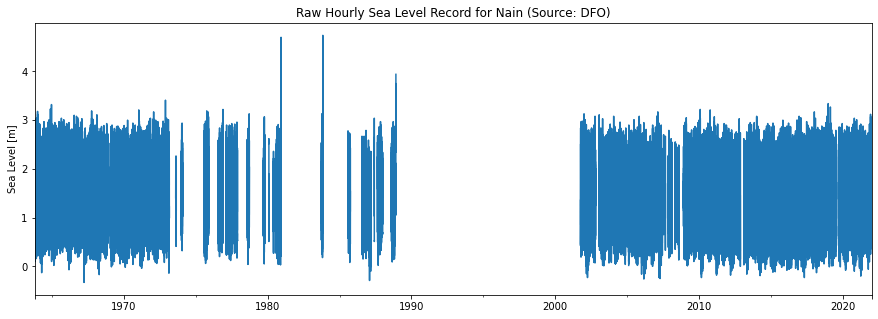

In [8]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot "height" column against index (which is the a datetime object)
df["SLEV(metres)"].plot(
    ax=ax          # use axis `ax` created above
)

# title and axis label
ax.set(
    title="Raw Hourly Sea Level Record for Nain (Source: DFO)",
    ylabel="Sea Level [m]"
)

## Tidal Analysis

From [UTide GitHub page](https://github.com/wesleybowman/UTide):

```
coef = solve(time, time_series_u, time_series_v,
             lat=30,
             nodal=False,
             trend=False,
             method='ols',
             conf_int='linear',
             Rayleigh_min=0.95,)
```

In [9]:
def tidal_analysis(ser, latitude):
    """ Wrapper function for tidal analsyis with UTide.

    Parameters
    ----------
    ser : `pandas.Series`
        Input sea level time seriesl.
    lat : float
        Latitude of tide gauge.

    Returns
    -------
    df_out : `pandas.DataFrame
        Tidal amplitudes and phases with confidence interval. Each row is for
        one tidal constituent.
    
    """
        
    # make a time variable in floating point days since a given epoch
    time = mdates.date2num(ser.index.to_pydatetime())
    
    # make sure there are some sea level values
    if not ser.isnull().all():
    
        # use UTide to run tidal analysis
        coef = solve(
            time, ser.values,   # input variables: time and sea level as numpy arrays
            lat=latitude,       # latitude of tide gauge
            nodal=False,       
            trend=False,
            method="ols",
            conf_int="linear",
            Rayleigh_min=0.95,
            verbose=False       # no messages
        )

        # combine amplitudes and phases and their confidence interval in `numpy.Array`
        data = np.c_[coef["A"], coef["A_ci"], coef["g"], coef["g_ci"]]
        
        # index
        index = coef["name"]
    
    # if `ser` only contains NaNs, return empty `pandas.DataFrame`
    else:
        data = None
        index = None
        
    
    # create output `pandas.DataFrame
    df_out = pd.DataFrame(
        data=data,
        index=index,
        columns=["A", "A_ci", "g", "g_ci"]
    )
    
    return df_out

### Tidal Analysis

Running the tidal analysis with default parameters for chunks of the gage record and plotting it binned by month.

In [10]:
result = df["SLEV(metres)"].loc["2010":"2021"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

In [11]:
result

A      A_ci           g        g_ci
time       constituent                                            
2010-01-31 M2           0.731837  0.002581   68.264652    0.201944
           S2           0.272563  0.002580    6.787737    0.542335
           N2           0.190982  0.002582  270.214611    0.773434
           K1           0.120441  0.006935  188.278770    3.304408
           O1           0.077060  0.006943  279.311057    5.158253
...                          ...       ...         ...         ...
2021-12-31 2SM6         0.001809  0.001781  272.010279   56.340402
           2MK5         0.001180  0.001717  323.502916   83.375748
           M8           0.001029  0.000530    3.891211   29.535727
           S4           0.000902  0.002138  180.667643  136.054575
           3MK7         0.000831  0.000836  233.812788   57.626637

[4569 rows x 4 columns]

#### Figure: Monthly M2 Amplitudes 2010-2022

[Text(0.5, 1.0, 'Monthly M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

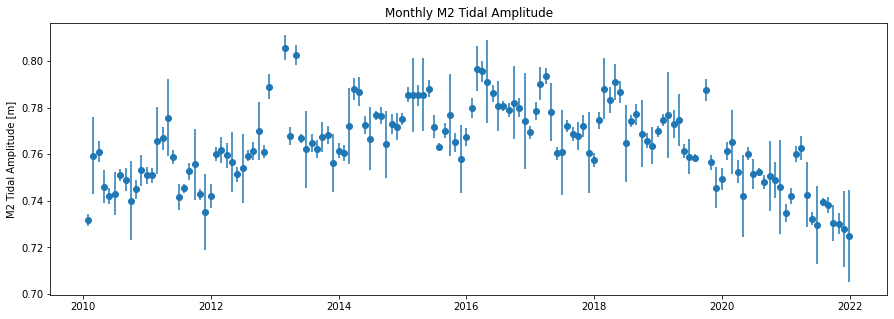

In [12]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Monthly {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)


The same analysis breaks for the longer record. For example, here are the results if we extend the dates:

In [13]:
result = df["SLEV(metres)"].loc["2009":"2022"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()
ds

<xarray.Dataset>
Dimensions:      (constituent: 35, time: 153)
Coordinates:
  * time         (time) datetime64[ns] 2009-01-31 2009-02-28 ... 2021-12-31
  * constituent  (constituent) object '2MK5' '2MN6' '2MS6' ... 'SN4' 'UPS1'
Data variables:
    A            (time, constituent) float64 0.0006958 0.008517 ... nan 0.002745
    A_ci         (time, constituent) float64 0.002005 0.002783 ... nan 0.005277
    g            (time, constituent) float64 297.1 289.7 84.7 ... nan 153.0
    g_ci         (time, constituent) float64 165.2 18.73 12.35 ... nan 110.2

#### Figure: Monthly M2 Amplitudes 2009-2022

[Text(0.5, 1.0, 'Monthly M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

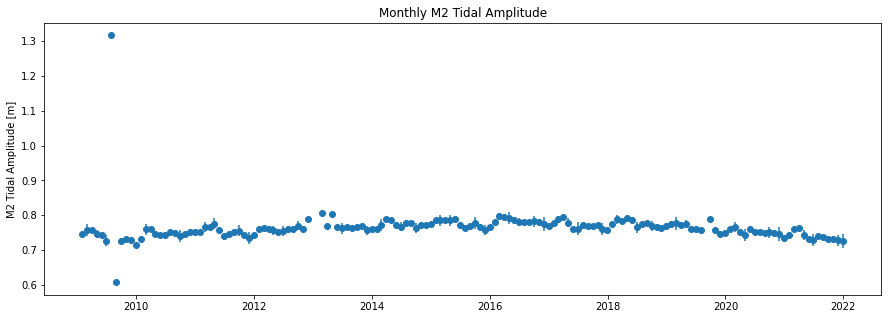

In [14]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Monthly {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
    #ylim=(0,3000)
)

If we compare the tidal analysis to the raw gage height data for the problematic year (2009) it looks like the issue might be related to missing data:

In [15]:
result = df["SLEV(metres)"].loc["2009":"2009"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

#### Figure: Monthly M2 Amplitudes 2009-2010

[Text(0.5, 1.0, 'Monthly M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

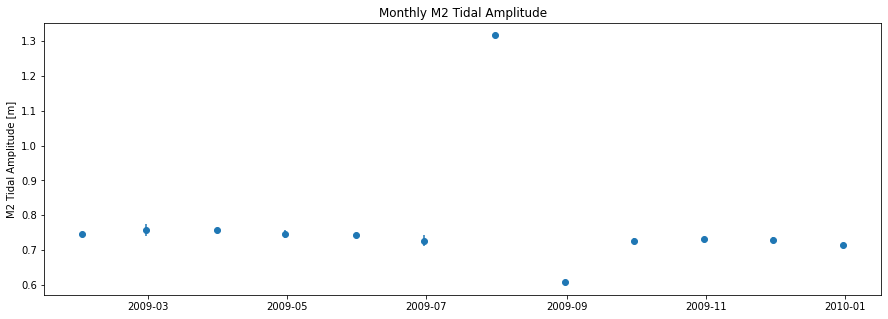

In [16]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Monthly {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

#### Figure: Raw Gage Height Data 2009-2010

[Text(0.5, 1.0, 'Raw Hourly Sea Level Record for Nain (Source: DFO)'),
 Text(0, 0.5, 'Sea Level [m]')]

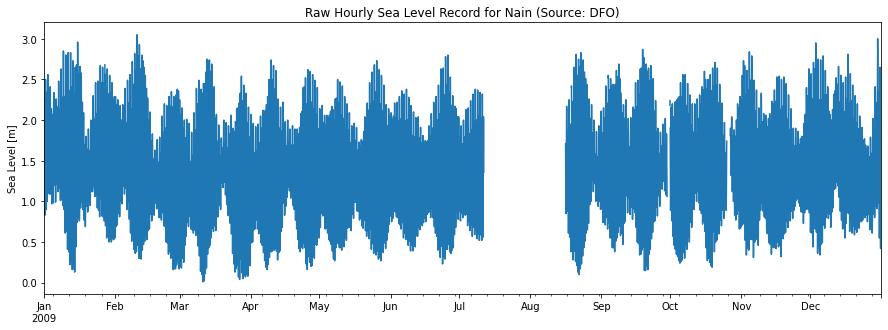

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot "height" column against index (which is the a datetime object)
df["SLEV(metres)"].loc["2009":"2009"].plot(
    ax=ax          # use axis `ax` created above
)

# title and axis label
ax.set(
    title="Raw Hourly Sea Level Record for Nain (Source: DFO)",
    ylabel="Sea Level [m]"
)

And if we compare the raw gage height data for this "bad" year to a "good" year (e.g., 2020) the raw values aren't off by much:

In [18]:
JuneNov_2020 = df["2020-06":"2020-11"]
JuneNov_2009 = df["2009-06":"2009-11"]

#### Figure: Raw Gage Height in 2009 vs.2020

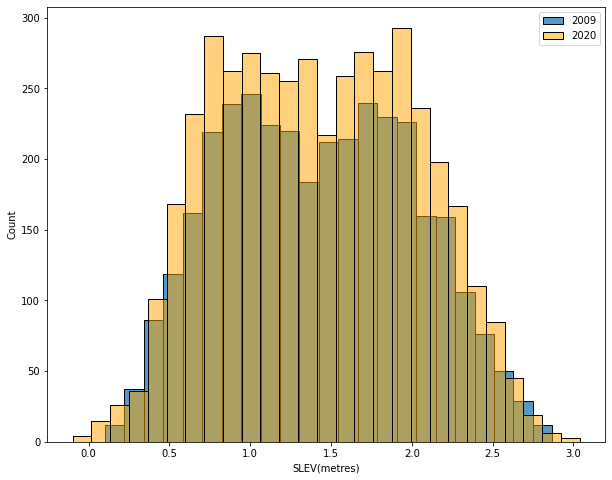

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

sns.histplot(JuneNov_2009['SLEV(metres)'])
sns.histplot(JuneNov_2020['SLEV(metres)'], color='orange', alpha=0.5)

plt.legend(labels=["2009","2020"])
plt.show()

And looking at the distribution for the entire record, it doesn't have a particularly long tail:

### Figure: Raw gage height data for the entire record

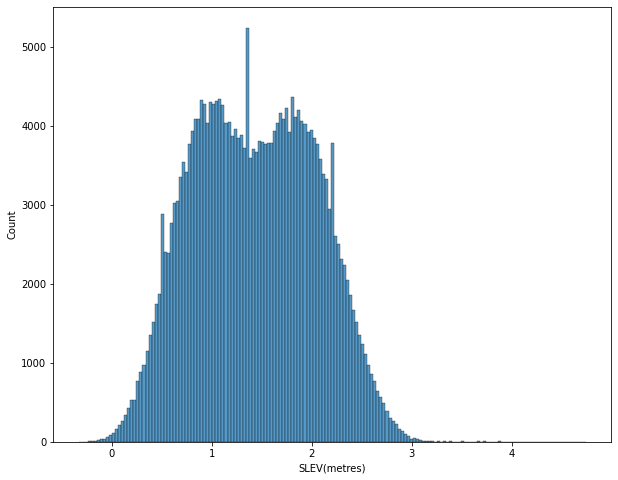

In [103]:
fig, ax = plt.subplots(figsize=(10,8))

sns.histplot(df['SLEV(metres)'])

plt.show()

A quick check of how the missing data are coded in the record:

In [20]:
df["2009-07-11 16:00:00" :"2009-08-16 07:00"]

,SLEV(metres)
2009-07-11 16:00:00,1.36
2009-07-11 17:00:00,NaN
2009-07-11 18:00:00,NaN
2009-07-11 19:00:00,NaN
2009-07-11 20:00:00,NaN
...,...
2009-08-16 03:00:00,NaN
2009-08-16 04:00:00,NaN
2009-08-16 05:00:00,NaN
2009-08-16 06:00:00,NaN


Based on the above, it appears that missing data creates the problem rather than an issue with the raw data. UTides was developed with this issue in mind:

### From the UTides docs:

"The primary goal is to develop a tidal analysis approach and accompanying software tool (“UTide”) that (a) integrates several existing tidal analysis methods with each other (Table 1), and (b) includes enhancements specifically designed to enable treatment of multi-year records with irregular temporal sampling."

What are the parameter adjustments within the code that can help with the tidal analysis on an extremely irregular timeseries?

Potential adjustments to the ut_solve parameter set:
* "When the times are irregular a crude but practical approach to being conservative,in the sense of omitting constituents that might not be resolved from each other, is to use the same diagnostics but judge them in relation to different threshold values. For example, if the Rayleigh criteria ((81),(82)) are used with R min =1 for a uniformly 37 sampled record, then for an irregularly sampled record an R min value higher than 1 can be used, in order to be more stringent in omitting constituents" (p. 37)


#### Adjusting the Rayleigh criteria.

Default example from the github page set Rayleight number to 0.95. Docs suggest R_min = 1 for evenly spaced data, and higher values for irregular data.

In [105]:
def tidal_analysis(ser, latitude):
    """ Wrapper function for tidal analsyis with UTide.

    Parameters
    ----------
    ser : `pandas.Series`
        Input sea level time seriesl.
    lat : float
        Latitude of tide gauge.

    Returns
    -------
    df_out : `pandas.DataFrame
        Tidal amplitudes and phases with confidence interval. Each row is for
        one tidal constituent.
    
    """
        
    # make a time variable in floating point days since a given epoch
    time = mdates.date2num(ser.index.to_pydatetime())
    
    # make sure there are some sea level values
    if not ser.isnull().all():
    
        # use UTide to run tidal analysis
        coef = solve(
            time, ser.values,   # input variables: time and sea level as numpy arrays
            lat=latitude,       # latitude of tide gauge
            nodal=False,       
            trend=False,
            method="ols",
            conf_int="linear",
            Rayleigh_min=1.0,
            verbose=False       # no messages
        )

        # combine amplitudes and phases and their confidence interval in `numpy.Array`
        data = np.c_[coef["A"], coef["A_ci"], coef["g"], coef["g_ci"]]
        
        # index
        index = coef["name"]
    
    # if `ser` only contains NaNs, return empty `pandas.DataFrame`
    else:
        data = None
        index = None
        
    
    # create output `pandas.DataFrame
    df_out = pd.DataFrame(
        data=data,
        index=index,
        columns=["A", "A_ci", "g", "g_ci"]
    )
    
    return df_out

In [106]:
result = df["SLEV(metres)"].loc["2010":"2021"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

### Figure: Monthly M2 Amplitudes 2009-2021 **R_min = 1**

[Text(0.5, 1.0, 'Monthly M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

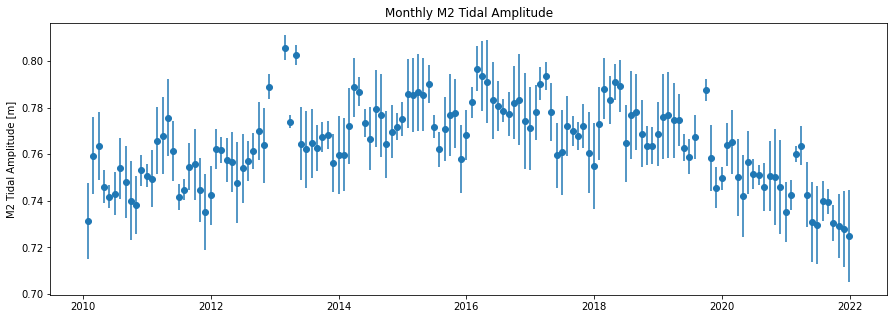

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Monthly {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

Helps for the year 2009, but still breaks when the record is extended further back. 

For the R_min = 0.95 (default) In 2009, the anomalously large amplitude is 1.3 meters - but the tidal analysis estimates **much** larger tidal amplitudes for other parts of the record. For example, if we look at 2007, the values are absolutely nuts:

In [108]:
# pandas magic
result = df["SLEV(metres)"].loc["2007":"2009"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

/Users/dilemmajayne/opt/anaconda3/lib/python3.7/site-packages/utide/confidence.py:243: RuntimeWarning: invalid value encountered in sqrt
  sig1, sig2 = ut_linci(Xu[c], Yu[c], np.sqrt(varXu), np.sqrt(varYu))


#### Figure: Monthly M2 Amplitudes 2007-2008 **R_min = 1**

[Text(0.5, 1.0, 'Monthly M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

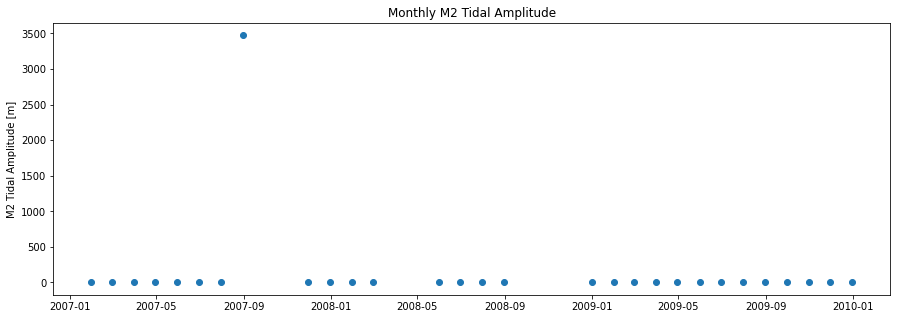

In [109]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Monthly {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

*What happens as you continue to adjust the R_min paramter?*

* R_min 1-1.1 : results are identical to the plot above ^^
* R_min 1.2-2: plot looks like the one above, but the outlier position moves from 3500 m to 12000 m (worse!)
* R_min 2.1-20: all of the binned M2 amplitudes are <= 1 m; but the error bars are huge. 

In [169]:
def tidal_analysis(ser, latitude):
    """ Wrapper function for tidal analsyis with UTide.

    Parameters
    ----------
    ser : `pandas.Series`
        Input sea level time seriesl.
    lat : float
        Latitude of tide gauge.

    Returns
    -------
    df_out : `pandas.DataFrame
        Tidal amplitudes and phases with confidence interval. Each row is for
        one tidal constituent.
    
    """
        
    # make a time variable in floating point days since a given epoch
    time = mdates.date2num(ser.index.to_pydatetime())
    
    # make sure there are some sea level values
    if not ser.isnull().all():
    
        # use UTide to run tidal analysis
        coef = solve(
            time, ser.values,   # input variables: time and sea level as numpy arrays
            lat=latitude,       # latitude of tide gauge
            nodal=False,       
            trend=False,
            method="ols",
            conf_int="linear",
            Rayleigh_min=2.1,
            verbose=False       # no messages
        )

        # combine amplitudes and phases and their confidence interval in `numpy.Array`
        data = np.c_[coef["A"], coef["A_ci"], coef["g"], coef["g_ci"]]
        
        # index
        index = coef["name"]
    
    # if `ser` only contains NaNs, return empty `pandas.DataFrame`
    else:
        data = None
        index = None
        
    
    # create output `pandas.DataFrame
    df_out = pd.DataFrame(
        data=data,
        index=index,
        columns=["A", "A_ci", "g", "g_ci"]
    )
    
    return df_out

In [170]:
result = df["SLEV(metres)"].loc["2007":"2009"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

[Text(0.5, 1.0, 'Monthly M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

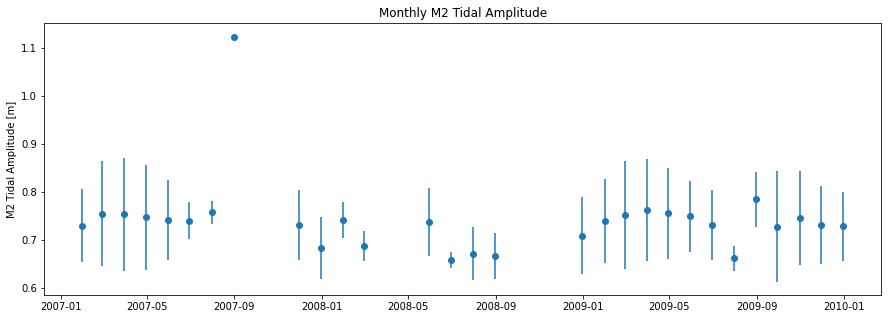

In [171]:
# create figure with one subplot axis with size 15x5 inches
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Monthly {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

**Adjusting the R_min to 2.1 or higher makes it impossible to see any trends in the full record.**

### Monthly M2 Amplitude for the entire record:

In [172]:
# pandas magic
result = df["SLEV(metres)"].loc["1963":"2021"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

/Users/dilemmajayne/opt/anaconda3/lib/python3.7/site-packages/utide/confidence.py:243: RuntimeWarning: invalid value encountered in sqrt
  sig1, sig2 = ut_linci(Xu[c], Yu[c], np.sqrt(varXu), np.sqrt(varYu))
/Users/dilemmajayne/opt/anaconda3/lib/python3.7/site-packages/utide/confidence.py:240: RuntimeWarning: invalid value encountered in double_scalars
  varXu = Puu[c] * varXu / den
/Users/dilemmajayne/opt/anaconda3/lib/python3.7/site-packages/utide/confidence.py:241: RuntimeWarning: invalid value encountered in double_scalars
  varYu = Puu[c] * varYu / den


[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

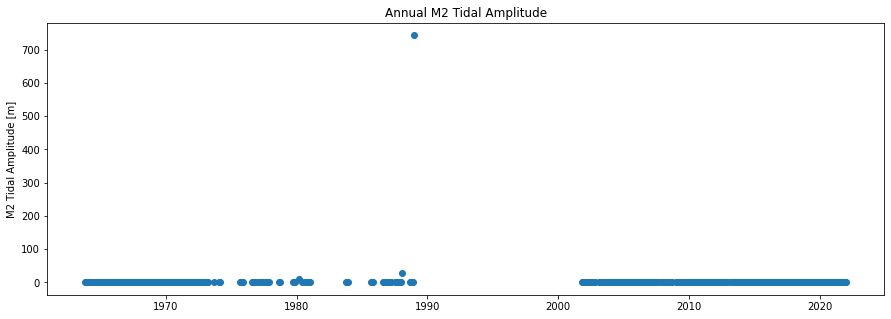

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

### Restricting the visualization to the "reasonable" results range:

[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]'),
 (0.6, 0.9)]

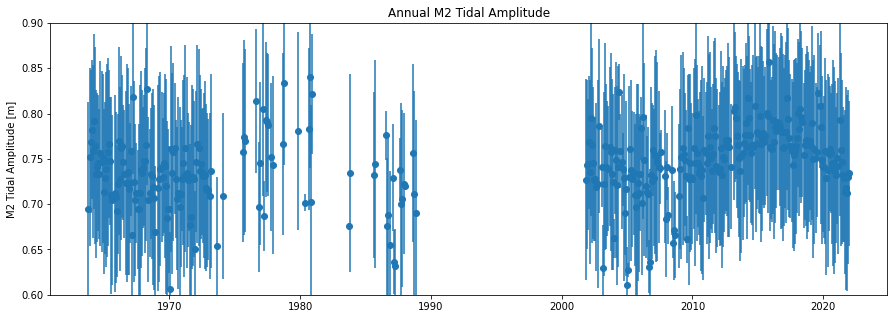

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
    ylim=(0.6,0.9)
)

### Compared to what you can see with R_min = 1

In [175]:
def tidal_analysis(ser, latitude):
    """ Wrapper function for tidal analsyis with UTide.

    Parameters
    ----------
    ser : `pandas.Series`
        Input sea level time seriesl.
    lat : float
        Latitude of tide gauge.

    Returns
    -------
    df_out : `pandas.DataFrame
        Tidal amplitudes and phases with confidence interval. Each row is for
        one tidal constituent.
    
    """
        
    # make a time variable in floating point days since a given epoch
    time = mdates.date2num(ser.index.to_pydatetime())
    
    # make sure there are some sea level values
    if not ser.isnull().all():
    
        # use UTide to run tidal analysis
        coef = solve(
            time, ser.values,   # input variables: time and sea level as numpy arrays
            lat=latitude,       # latitude of tide gauge
            nodal=False,       
            trend=False,
            method="ols",
            conf_int="linear",
            Rayleigh_min=1.0,
            verbose=False       # no messages
        )

        # combine amplitudes and phases and their confidence interval in `numpy.Array`
        data = np.c_[coef["A"], coef["A_ci"], coef["g"], coef["g_ci"]]
        
        # index
        index = coef["name"]
    
    # if `ser` only contains NaNs, return empty `pandas.DataFrame`
    else:
        data = None
        index = None
        
    
    # create output `pandas.DataFrame
    df_out = pd.DataFrame(
        data=data,
        index=index,
        columns=["A", "A_ci", "g", "g_ci"]
    )
    
    return df_out

In [176]:
result = df["SLEV(metres)"].loc["1963":"2021"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

/Users/dilemmajayne/opt/anaconda3/lib/python3.7/site-packages/utide/confidence.py:243: RuntimeWarning: invalid value encountered in sqrt
  sig1, sig2 = ut_linci(Xu[c], Yu[c], np.sqrt(varXu), np.sqrt(varYu))
/Users/dilemmajayne/opt/anaconda3/lib/python3.7/site-packages/utide/confidence.py:240: RuntimeWarning: invalid value encountered in double_scalars
  varXu = Puu[c] * varXu / den
/Users/dilemmajayne/opt/anaconda3/lib/python3.7/site-packages/utide/confidence.py:241: RuntimeWarning: invalid value encountered in double_scalars
  varYu = Puu[c] * varYu / den


Still get the same outlier dominated full record - compare the outlier at y=7000 for R_min=2 with y=700000000 for R_min=1

[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

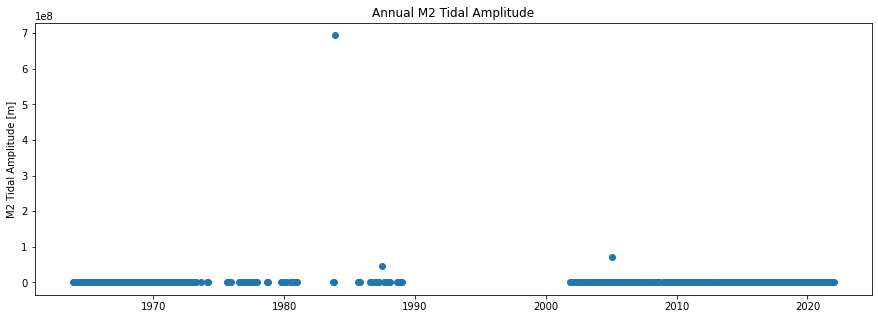

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

But with R_min=1 you can see trends that are lost when R_min=2 and the confidence intervals increase significantly

[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]'),
 (0.6, 0.9)]

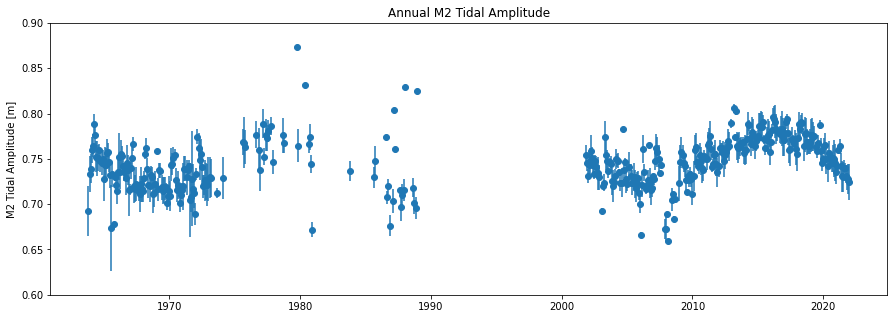

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
    ylim=(0.6,0.9)
)

NB I also tried adjusting *how* the confidence intervals are calculated (option for linear or Monte Carlo) but the MC approach breaks the operation.

### From the UTide docs:

* "In the case of irregular times, the spectral estimates are made using the un-normalized, mean-removed, Lomb-Scargle periodogram (Lomb 1976; Scargle 1982; Press et al. 1992). Calculation of the Lomb-Scargle periodogram requires specification of a frequency oversampling factor, the amount by which the grid of frequencies at which the periodogram estimates are computed is more dense than an equivalent FFT."

^^ This does not appear to be a parameter that you adjust. It must be automatically detecting whether the timestamps are linear or irregular?

To test this, I'm going to reload the dataset **without** reindexing it:

In [202]:
# read data into `pandas.DataFrame`
df = pd.read_csv(
    'DFO1430_full.csv',                         # Data downloaded from DFO 1430
    header=7,                                   # Seven line header
    parse_dates=[['Obs_date', 'Obs_time']],     # Identify date & time columns
)

# convert columns with date/time information to datetime object
df["time"] = pd.to_datetime(df["Obs_date_Obs_time"])

# remove the columns with date/time information
df = df.drop(["Obs_date_Obs_time"], axis=1)

# use the datetime object as index
df = df.set_index("time")

In [203]:
df.head(10)

,SLEV(metres)
time,
1963-10-17 05:00:00,0.53
1963-10-17 06:00:00,0.65
1963-10-17 07:00:00,0.97
1963-10-17 08:00:00,1.38
1963-10-17 09:00:00,1.87
1963-10-17 10:00:00,2.33
1963-10-17 11:00:00,2.53
1963-10-17 12:00:00,2.47
1963-10-17 13:00:00,2.19


### Figure: M2 Amplitude for the entire record

In [205]:
result = df["SLEV(metres)"].loc["1963":"2021"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

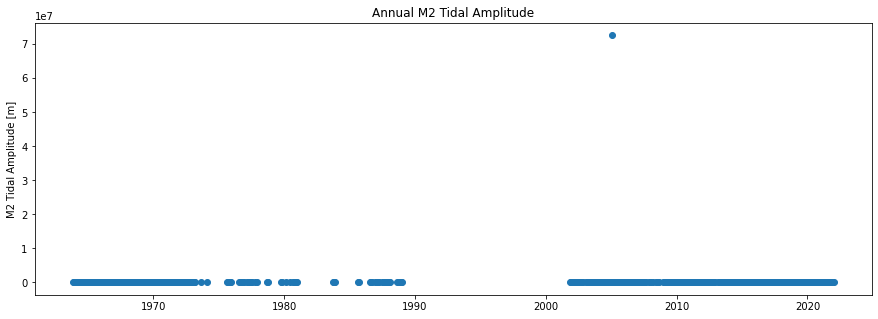

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

Pretty similar to the reindexed data, but the confidence intervals are larger when you zoom in:

[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]'),
 (0.6, 0.9)]

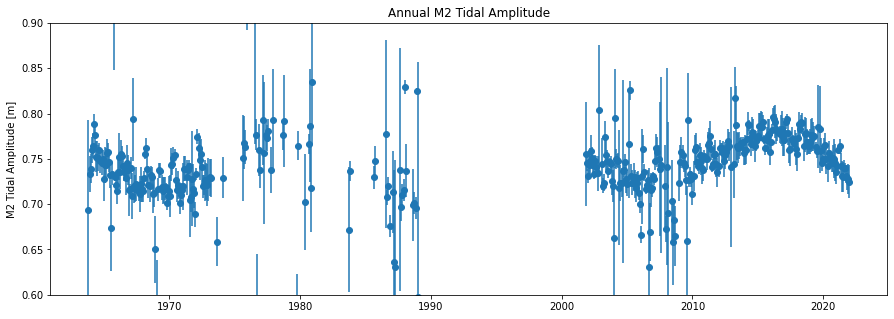

In [207]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
    ylim=(0.6,0.9)
)

### Figure: M2 Amplitude 2007-2022

Recalling that 2007-2009 were problematic with the reindexed dataset 

In [209]:
result = df["SLEV(metres)"].loc["2007":"2021"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

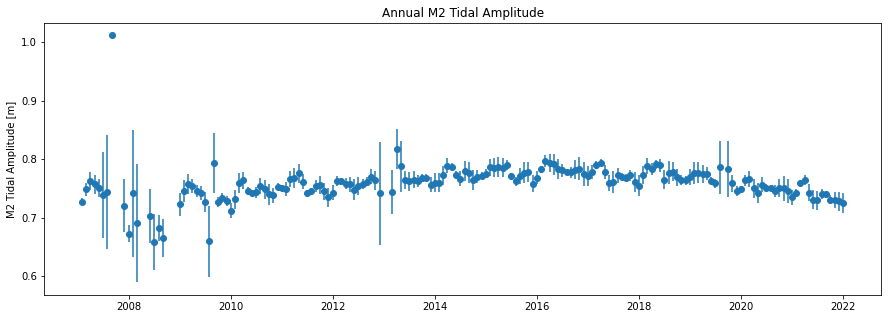

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

### Figure: 1963-1990

Looking only at the first part of the record:

In [211]:
result = df["SLEV(metres)"].loc["1963":"1990"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

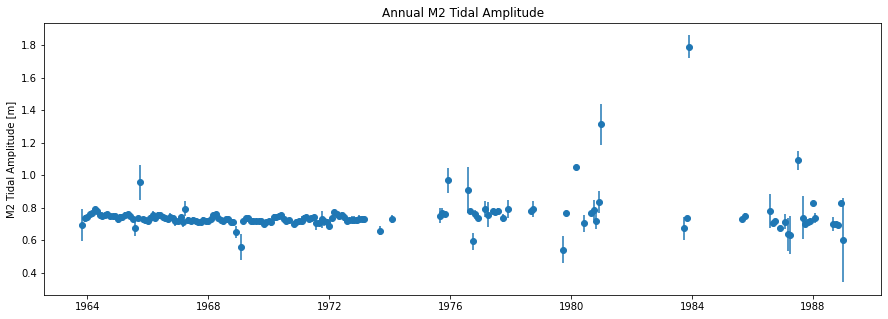

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

### Figure: 2001-2022

And at the second half of the record:

In [213]:
result = df["SLEV(metres)"].loc["2001":"2022"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

/Users/dilemmajayne/opt/anaconda3/lib/python3.7/site-packages/utide/confidence.py:243: RuntimeWarning: invalid value encountered in sqrt
  sig1, sig2 = ut_linci(Xu[c], Yu[c], np.sqrt(varXu), np.sqrt(varYu))


[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

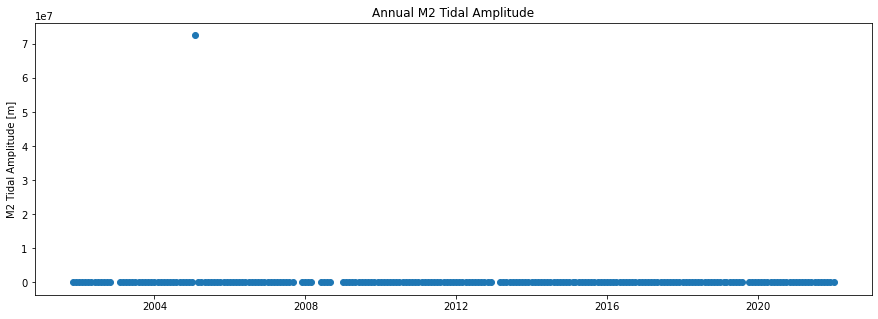

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

Just by **not** reindexing, most of the outliers are gone from the dataset! So UTides is automatically detecting whether the timeseries is irregular and choosing whether to solve the tidal components with a linear method or the Lomb-Scargle.

Next, will try adjusting the R_min on the non-reindexed data:

In [215]:
def tidal_analysis(ser, latitude):
    """ Wrapper function for tidal analsyis with UTide.

    Parameters
    ----------
    ser : `pandas.Series`
        Input sea level time seriesl.
    lat : float
        Latitude of tide gauge.

    Returns
    -------
    df_out : `pandas.DataFrame
        Tidal amplitudes and phases with confidence interval. Each row is for
        one tidal constituent.
    
    """
        
    # make a time variable in floating point days since a given epoch
    time = mdates.date2num(ser.index.to_pydatetime())
    
    # make sure there are some sea level values
    if not ser.isnull().all():
    
        # use UTide to run tidal analysis
        coef = solve(
            time, ser.values,   # input variables: time and sea level as numpy arrays
            lat=latitude,       # latitude of tide gauge
            nodal=False,       
            trend=False,
            method="ols",
            conf_int="linear",
            Rayleigh_min=2.0,
            verbose=False       # no messages
        )

        # combine amplitudes and phases and their confidence interval in `numpy.Array`
        data = np.c_[coef["A"], coef["A_ci"], coef["g"], coef["g_ci"]]
        
        # index
        index = coef["name"]
    
    # if `ser` only contains NaNs, return empty `pandas.DataFrame`
    else:
        data = None
        index = None
        
    
    # create output `pandas.DataFrame
    df_out = pd.DataFrame(
        data=data,
        index=index,
        columns=["A", "A_ci", "g", "g_ci"]
    )
    
    return df_out

### Second half of the record:

In [216]:
result = df["SLEV(metres)"].loc["2001":"2022"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

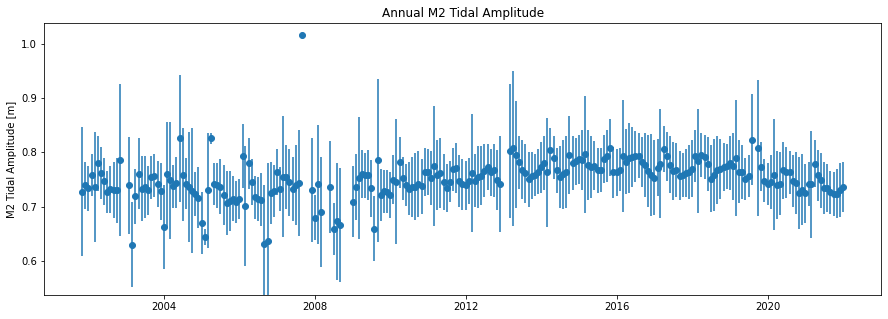

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

### Full record:

In [218]:
result = df["SLEV(metres)"].loc["1963":"2022"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [m]')]

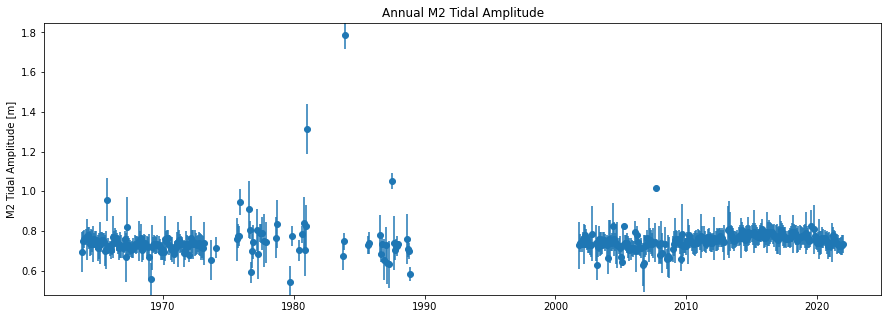

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [m]",
)

### Using "Research Quality" raw data from UHSLC:

And since those large outliers match up with the outliers in the raw data, we can test this with the dataset from UHSLC which has been cleaned up:

In [225]:
# URL to dataset on UHSLC website
url = "http://uhslc.soest.hawaii.edu/data/csv/rqds/atlantic/hourly/h833a.csv"

# read data into `pandas.DataFrame`
df = pd.read_csv(
    url,                                              # URL to dataset on UHSLC website
    header=None,                                      # the dataset doesn't have a header
    names=["year", "month", "day", "hour", "height"], # name columns
    na_values=-32767                                  # set invalid values to NaN
)

# convert columns with date/time information to datetime object
# https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
df["time"] = pd.to_datetime(df[["year", "month", "day", "hour"]])

# use the datetime object as index (this will make things much easier)
df = df.set_index("time")

# remove the columns with date/time information
# (all the information is now contained in the index)
df = df.drop(["year", "month", "day", "hour"], axis=1)
df = df.dropna() # I checked and there are nans in this record - so I dropped them to make sure the timeseries is irregular
df

,height
time,
1963-10-17 05:00:00,530.0
1963-10-17 06:00:00,650.0
1963-10-17 07:00:00,970.0
1963-10-17 08:00:00,1380.0
1963-10-17 09:00:00,1870.0
...,...
2018-12-31 19:00:00,1889.0
2018-12-31 20:00:00,1821.0
2018-12-31 21:00:00,1633.0


In [226]:
result = df["height"].loc["1963":"2022"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [mm]')]

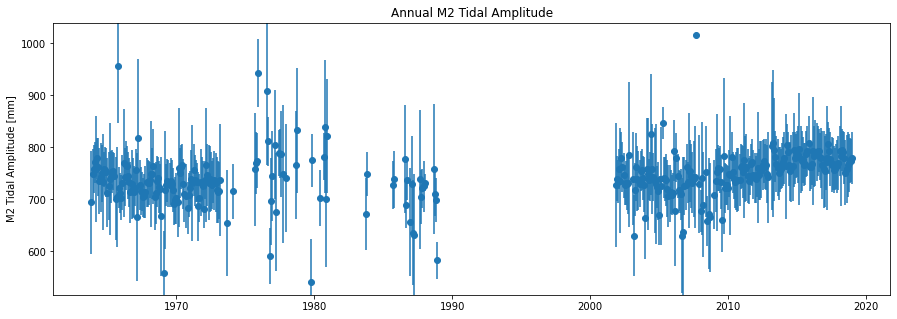

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [mm]",
)

Note that the differences in y-axis are because the DFO data is in [m] and the UHSLC data is in [mm].

Another test to compare R_min of 1 vs R_min of 2 using the UHSLC data:

In [238]:
def tidal_analysis(ser, latitude):
    """ Wrapper function for tidal analsyis with UTide.

    Parameters
    ----------
    ser : `pandas.Series`
        Input sea level time seriesl.
    lat : float
        Latitude of tide gauge.

    Returns
    -------
    df_out : `pandas.DataFrame
        Tidal amplitudes and phases with confidence interval. Each row is for
        one tidal constituent.
    
    """
        
    # make a time variable in floating point days since a given epoch
    time = mdates.date2num(ser.index.to_pydatetime())
    
    # make sure there are some sea level values
    if not ser.isnull().all():
    
        # use UTide to run tidal analysis
        coef = solve(
            time, ser.values,   # input variables: time and sea level as numpy arrays
            lat=latitude,       # latitude of tide gauge
            nodal=False,       
            trend=False,
            method="ols",
            conf_int="linear",
            Rayleigh_min=1.0,
            verbose=False       # no messages
        )

        # combine amplitudes and phases and their confidence interval in `numpy.Array`
        data = np.c_[coef["A"], coef["A_ci"], coef["g"], coef["g_ci"]]
        
        # index
        index = coef["name"]
    
    # if `ser` only contains NaNs, return empty `pandas.DataFrame`
    else:
        data = None
        index = None
        
    
    # create output `pandas.DataFrame
    df_out = pd.DataFrame(
        data=data,
        index=index,
        columns=["A", "A_ci", "g", "g_ci"]
    )
    
    return df_out

In [239]:
result = df["height"].loc["1963":"2022"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

/Users/dilemmajayne/opt/anaconda3/lib/python3.7/site-packages/utide/confidence.py:243: RuntimeWarning: invalid value encountered in sqrt
  sig1, sig2 = ut_linci(Xu[c], Yu[c], np.sqrt(varXu), np.sqrt(varYu))


[Text(0.5, 1.0, 'Annual M2 Tidal Amplitude'),
 Text(0, 0.5, 'M2 Tidal Amplitude [mm]')]

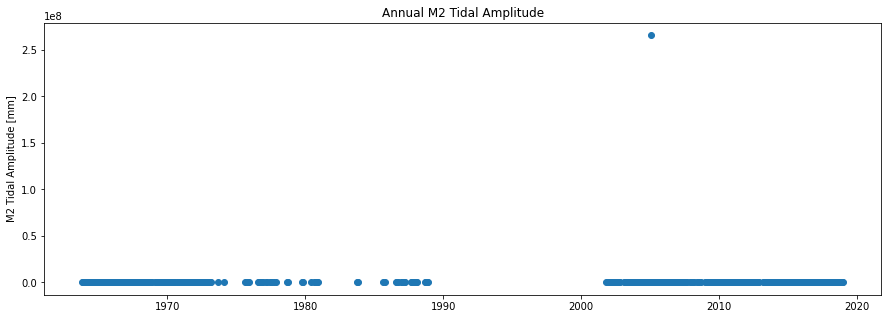

In [240]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [mm]",
)

The lowest R_min that gives a "good" result is 1.2 - appears the same as the figure plotting the UHSLC entire record with R_min=2

In [241]:
def tidal_analysis(ser, latitude):
    """ Wrapper function for tidal analsyis with UTide.

    Parameters
    ----------
    ser : `pandas.Series`
        Input sea level time seriesl.
    lat : float
        Latitude of tide gauge.

    Returns
    -------
    df_out : `pandas.DataFrame
        Tidal amplitudes and phases with confidence interval. Each row is for
        one tidal constituent.
    
    """
        
    # make a time variable in floating point days since a given epoch
    time = mdates.date2num(ser.index.to_pydatetime())
    
    # make sure there are some sea level values
    if not ser.isnull().all():
    
        # use UTide to run tidal analysis
        coef = solve(
            time, ser.values,   # input variables: time and sea level as numpy arrays
            lat=latitude,       # latitude of tide gauge
            nodal=False,       
            trend=False,
            method="ols",
            conf_int="linear",
            Rayleigh_min=1.2,
            verbose=False       # no messages
        )

        # combine amplitudes and phases and their confidence interval in `numpy.Array`
        data = np.c_[coef["A"], coef["A_ci"], coef["g"], coef["g_ci"]]
        
        # index
        index = coef["name"]
    
    # if `ser` only contains NaNs, return empty `pandas.DataFrame`
    else:
        data = None
        index = None
        
    
    # create output `pandas.DataFrame
    df_out = pd.DataFrame(
        data=data,
        index=index,
        columns=["A", "A_ci", "g", "g_ci"]
    )
    
    return df_out

In [242]:
result = df["height"].loc["1963":"2022"].groupby(pd.Grouper(freq="M")).apply(lambda x: tidal_analysis(x, lat))
result.index.set_names(["time", "constituent"], inplace=True)

ds = result.to_xarray()

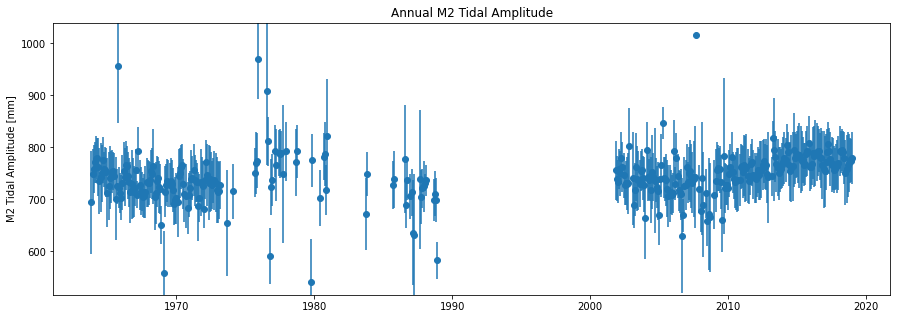

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

constituent = "M2"

# monthly tidal amplitude and confidence intervals
ax.errorbar(
    ds["time"].values, ds["A"].sel(constituent=constituent),
    yerr=ds["A_ci"].sel(constituent=constituent),
    fmt="o"
)

# title and axis label
ax.set(
    title=f"Annual {constituent} Tidal Amplitude",
    ylabel=f"{constituent} Tidal Amplitude [mm]",
)

plt.savefig('nain_tides.tif')